## Deconvolution iwith Unrolled ADMM

This notebook is a tutorial on deconvolving galaxy images using the suggested unrolled ADMM model.

In [1]:
import sys
sys.path.append('../')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import galsim
from models.Unrolled_ADMM import Unrolled_ADMM
from models.Richard_Lucy import Richard_Lucy
from models.Tikhonet import Tikhonov, Tikhonet
from models.Wiener import Wiener
from utils.utils_test import PSNR, estimate_shear_new

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/tianaoli/.conda/envs/astro/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read in Images

In [2]:
psf = torch.load("psf_23.5_0.pth")
obs = torch.load("obs_23.5_0.pth")
gt = torch.load("gt_23.5_0.pth")
# obs = (obs - obs.min())/(obs.max() - obs.min())
# gt = (gt - gt.min())/(gt.max() - gt.min())

## Load in Trained Model

You can choose the numer of iterations you want for the unrolled ADMM model. We provide pretrained weights for iteration number 1,2,4 and 8.

In [3]:
n_iters = 2                 # number of iterations
model_file = f'../saved_models2/Poisson_PnP_{n_iters}iters_50epochs.pth'

# model = Unrolled_ADMM(n_iters=n_iters, llh='Poisson', PnP=True)
model = Tikhonov()
model.to(device)
model.eval()
# model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
print(f'Successfully loaded in {model_file}.')

Successfully loaded in ../saved_models2/Poisson_PnP_2iters_50epochs.pth.


## Deconvolution

In [4]:
# calculate average photon level
alpha = obs.ravel().mean()
alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

output = model(obs.unsqueeze(0).unsqueeze(0).to(device), psf.unsqueeze(0).unsqueeze(0).to(device), alpha.to(device))
rec = (output.cpu() * alpha.cpu()).squeeze(dim=0).squeeze(dim=0).detach()

## Visualization

Text(0.5, 1.0, 'Deconvolved Galaxy')

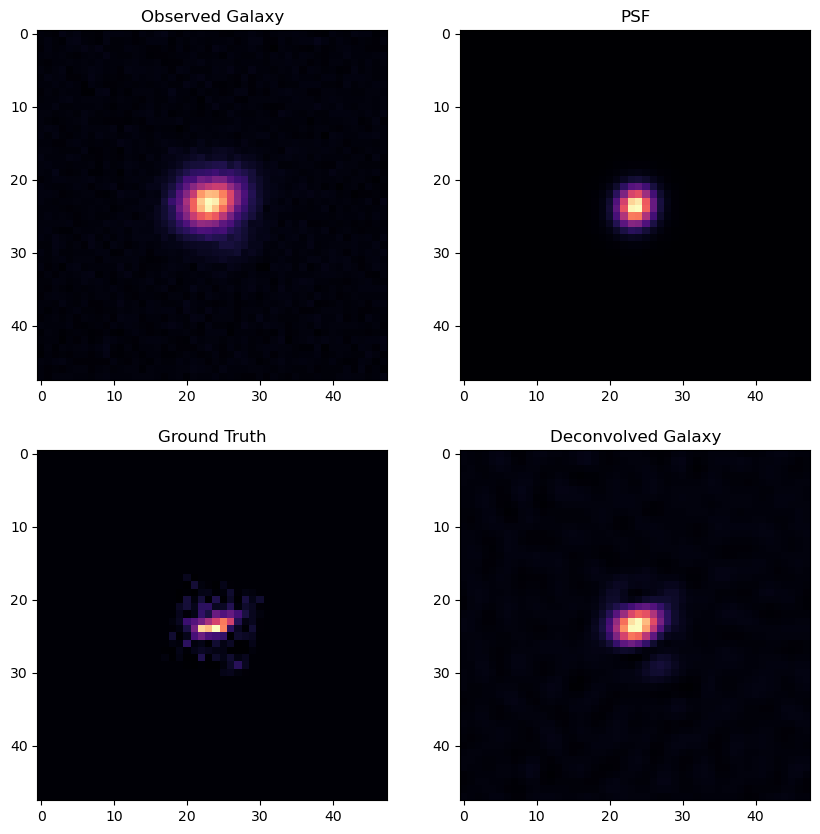

In [5]:
cmap = 'magma'
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(obs, cmap=cmap)
plt.title('Observed Galaxy')
plt.subplot(2,2,2)
plt.imshow(psf, cmap=cmap)
plt.title('PSF')
plt.subplot(2,2,3)
plt.imshow(gt, cmap=cmap)
plt.title('Ground Truth')
plt.subplot(2,2,4)
plt.imshow(rec, cmap=cmap)
plt.title('Deconvolved Galaxy')

# print(estimate_shear(obs.numpy()))
# print(estimate_shear(rec.numpy()))
# print(estimate_shear(gt.numpy()))